In [1]:
# 2D Toy training example
# Goal: examine how the gradients change the center and sigma of a single neuron
# Conclusions: Center Gradients are correct (moves to the right center)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
# random seeds
# torch.manual_seed(1665)
# np.random.seed(3266)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [6]:
!gpustat

crescent                Fri Feb  5 19:55:58 2021  418.152.00
[0] GeForce RTX 2080 Ti | 81'C,   0 % |  6786 / 10989 MB | near(1271M) near(5504M)
[1] GeForce RTX 2080 Ti | 42'C,   0 % |    11 / 10989 MB |


In [7]:
# Define what device we are using

# manualy set cuda device
# torch.cuda.set_device(1)

print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  False


/home/felix/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
# Define 2d Toy Data

# number of dimensions of the data
num_dim = 2

# gaussian target parameters
data_centers = 1*np.ones(num_dim)
sigma = 1

# hyper-plane separating the classes (this will become the target for the weights)
# sep_plane = np.random.uniform(low=-1.0, high=1.0, size=num_dim)
# sep_plane = np.concatenate(([1],np.zeros(num_dim-1)))
sep_plane = [-1.5,1]

num_samples = 4000
# stretch = [3, 1]
# rotate = -np.pi/4
stretch = [1,1]
rotate = 0


samples_xs = np.array([stretch*np.random.normal(loc=0, scale=sigma, size=num_dim)+data_centers for _ in range(num_samples)] )

# rotate
samples_xs = np.array([(np.cos(rotate)*x1-np.sin(rotate)*x2,
                        np.sin(rotate)*x1+np.cos(rotate)*x2)  for (x1,x2) in samples_xs])

data_centers = [np.cos(rotate)*data_centers[0]-np.sin(rotate)*data_centers[1],
                        np.sin(rotate)*data_centers[0]+np.cos(rotate)*data_centers[1]]

sep_plane = [np.cos(rotate)*sep_plane[0]-np.sin(rotate)*sep_plane[1],
                        np.sin(rotate)*sep_plane[0]+np.cos(rotate)*sep_plane[1]]

# apply labels based on side of sep hyper plane
samples_labels = np.array([ [1] if x>np.matmul(data_centers, sep_plane) else [-1] for x in np.matmul(samples_xs, sep_plane)])


# shuffle in unison
permutation = np.random.permutation(len(samples_xs))
for old_index, new_index in enumerate(permutation):
    samples_xs[new_index] = samples_xs[old_index]
    samples_labels[new_index] = samples_labels[old_index]

<IPython.core.display.Javascript object>


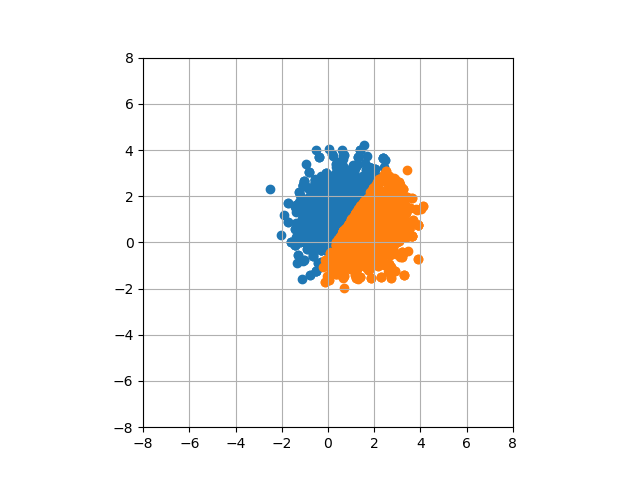

In [9]:
# 2D Check 
samples_x_1 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==1]
samples_y_1 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==1]

samples_x_2 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==-1]
samples_y_2 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==-1]

plt.scatter(samples_x_1, samples_y_1)
plt.scatter(samples_x_2, samples_y_2)
plt.axis([-8,8, -8,8])
plt.grid(True)
plt.gca().set_aspect("equal")
plt.show()

In [10]:
# convert data to pytorch format 
tensor_x = torch.Tensor(samples_xs)
tensor_y = torch.Tensor(samples_labels)

slice_bound = int(num_samples*4/5)
my_dataset = torch.utils.data.TensorDataset(tensor_x[:slice_bound],tensor_y[:slice_bound]) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_x[slice_bound:],tensor_y[slice_bound:]) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=4000, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data) # create your dataloader

In [11]:
# heatmap params
from matplotlib import cm
# scale of the heat maps
scale = np.ceil(np.max(samples_xs))
X1 = np.arange(-scale,scale+0.1, 0.1)
X2 = np.arange(-scale,scale+0.1, 0.1)
X1s, X2s = np.meshgrid(X1,X2)
heatmap_inputs = np.reshape(list(zip(X1s.flatten(),X2s.flatten())),(-1,2))

In [12]:
### Define the FGN

In [13]:
# Define a Finite Gaussian Neural Network

covar_type = 'sphere'
ordinal= float(2)
free_biases = False

class FGNet(nn.Module):
    def __init__(self):
        super(FGNet, self).__init__()
        self.fl = fgnl.FGN_layer(2,1, covar_type=covar_type, ordinal=ordinal, free_biases=free_biases)
        
        self.covar_type = covar_type

    def forward(self, x):
        x,_ = self.fl(x)
        # clip res to +-1 for MSE loss
#         x  = torch.tanh(x, min=-1.0, max=1.0)
        x = torch.tanh(x)
    
        return x

In [14]:
# Initialize the network
model = FGNet().to(device)

In [15]:
model.state_dict()

OrderedDict([('fl.weights', tensor([[-0.3525,  0.6714]])),
             ('fl.biases', tensor([0.0573])),
             ('fl.centers', tensor([[ 0.1330, -0.0154]])),
             ('fl.inv_covars', tensor([1.4513]))])

In [16]:
# increase range of neuron
if covar_type in ['sphere', 'diag']:
    model.fl.inv_covars = torch.nn.Parameter(model.fl.inv_covars/8.0)
elif covar_type in ['full', 'half_full']:
    # this should be fixed, but im not 100% on how the full matrix affects range
    model.fl.inv_covars = torch.nn.Parameter(model.fl.inv_covars/100.0)

In [17]:
# model stats
print(model)
print([p.size() for p in list(model.parameters())])
# print([p for p in list(model.parameters())])
print("Training?", model.training) 
print(model.state_dict())

print("losses")
print(fgnh.l2_loss(model))
print(fgnl.sigmas_loss(model))

FGNet(
  (fl): FGN_layer()
)
[torch.Size([1, 2]), torch.Size([1]), torch.Size([1, 2]), torch.Size([1])]
Training? True
OrderedDict([('fl.weights', tensor([[-0.3525,  0.6714]])), ('fl.biases', tensor([0.0573])), ('fl.centers', tensor([[ 0.1330, -0.0154]])), ('fl.inv_covars', tensor([0.1814]))])
losses
tensor([0.5750], grad_fn=<DivBackward0>)
tensor([30.3860], grad_fn=<DivBackward0>)


In [18]:
# initial activity (gaussian, full)
# visualize neuron activity over data space
# extracts the parameters and shows theoritial neuron activity

# combining circular gaussian with normal neuron
# neuron parameters (weights, bias)
W = model.fl.weights.detach().numpy()[0]
print("weights:",W)

# radial parameters
center = model.fl.centers.detach().numpy()[0] # controls the center of gaussian (<=> bias of neuron)
# plot center as red dot
plt.plot(center[0], center[1], marker='o', markersize=4, color="red")

print("center:",center)

# if bias is defined by center
b1 = -np.matmul(W,center)
# if bias is a free param
b2 = model.fl.biases.detach().numpy()[0]
print("bias from centers:",b1)
print("bias from params (same if free_biases==False):",b2)
# new zero line
zero_line = -(W[0]*X1+b2)/W[1]

# heatmap neuronal activity
n_activity = np.tanh(np.sum(W*heatmap_inputs, axis=1)+b2)
# print(n_activity.shape)

distances = heatmap_inputs-center

# heatmap radial activity 
if covar_type == 'sphere':
    inv_covar = model.fl.inv_covars.detach().numpy()[0]
    sig = 1.0/inv_covar
    r_activity = np.exp((-1.0/abs(sig)**2) *  np.sum(np.square(heatmap_inputs-center), axis=1))
    
elif covar_type == 'diag':
    inv_covar = model.fl.inv_covars.detach().numpy()[0]
    sig = 1.0/inv_covar
    ded = np.einsum('ij,ij->i', distances*abs(inv_covar)**2, distances)
    r_activity = np.exp(-ded)

elif covar_type == 'full':
    inv_covar = model.fl.inv_covars.detach().numpy()[0]
    sig = np.linalg.inv(np.matmul(inv_covar,inv_covar))
    ded = np.einsum('lzi,zik,lzk->lz', distances, inv_covars, distances)
    r_activity = np.exp(-ded)
    
elif covar_type == 'chol':
    inv_covar = model.fl.inv_covars.detach().numpy()[0]
    sig = np.linalg.inv(np.matmul(inv_covar,inv_covar))
    ded = np.einsum('zi,ij,kj,zk->z', distances, inv_covar, inv_covar, distances)
    r_activity = np.exp(-ded)

print("inv covar:", inv_covar)
print("sig:", sig)

weights: [-0.35251203  0.6713622 ]
center: [ 0.1330105  -0.01543641]
bias from centers: 0.057251222
bias from params (same if free_biases==False): 0.057251222
inv covar: 0.18141097
sig: 5.51234585951831


<IPython.core.display.Javascript object>


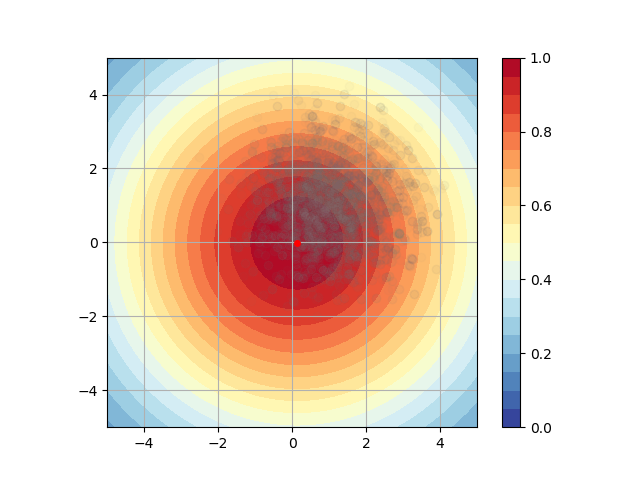

In [19]:
# draw just the gaussian activity and the data
plt.contourf(X1s, X2s, np.reshape(r_activity, np.shape(X1s) ), levels=np.arange(0,1.05, 0.05), cmap= mpl.cm.RdYlBu_r)

plt.colorbar(ticks=np.arange(0,1.1, 0.2))

# uncomment if you want to see the data and tighten the window
plt.scatter(samples_x_1, samples_y_1, alpha=0.03, c='gray')
plt.scatter(samples_x_2, samples_y_2, alpha=0.03, c='gray')
# plt.axis([-1.5,2.5, -1, 1.5])

#reset axes
plt.axis([-5,5, -5, 5])
plt.grid(True)
plt.gca().set_aspect("equal")
plt.show()

<IPython.core.display.Javascript object>


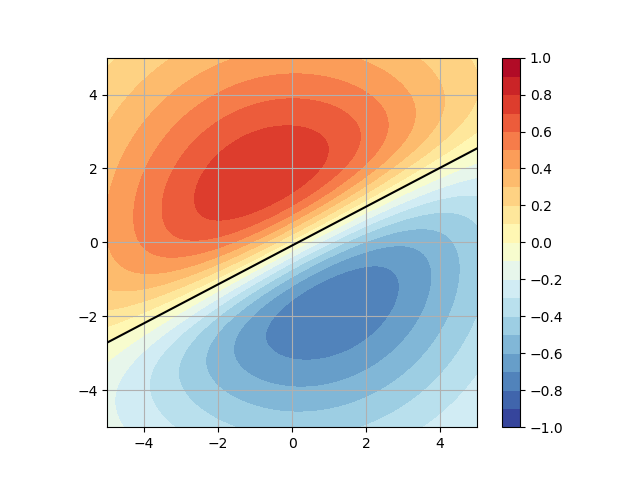

In [20]:
# overall heatmap activity
activity = n_activity*r_activity
# clip to +-1
# activity = np.clip(activity, a_max=0.999, a_min=-1.0)

# plot the zero line
plt.plot(X1,zero_line, color='black')
# plot the heatmap 
# maxi = 1.0
# levels = np.arange(-maxi, maxi+0.1,maxi/10.0)
# ticks = np.arange(-maxi, maxi+0.1, maxi/5.0)


plt.contourf(X1s, X2s, np.reshape(activity, np.shape(X1s) ), levels=np.arange(-1,1.05, 0.1), cmap=cm.RdYlBu_r)

plt.colorbar(ticks=np.arange(-1,1.1, 0.2))
#reset axes
plt.axis([-5,5, -5, 5])
plt.grid(True)
plt.gca().set_aspect("equal")
plt.show()

In [21]:
### Training

In [22]:
# importances of the constraints
lmbda_l2 = (1.0*0.1/len(my_dataloader.dataset))
lmbda_sigs = 0.005
    
print(lmbda_l2)
print(lmbda_sigs)

# loss function
def loss_func(model, output, target):
    
    # normal MSE loss
    mse_loss = F.mse_loss(output, target)
    
    # sum of sigma squares loss
    sig_loss = fgnl.sigmas_loss(model)

    # l2 loss
    l2_loss = fgnh.l2_loss(model)
    
    # (old) negative log likelihood over gaussian loss
#     nllg_loss = 100.0*lmbda*torch.sum(likelihood)
#     nllg_loss = 0.0*torch.mean(likelihood)
    
    return mse_loss + lmbda_l2*l2_loss + lmbda_sigs*sig_loss 

3.125e-05
0.005


In [23]:
# number of correct pred function
def pred_func(output, target):
    # (old)split output into pred and likelihoods
#     output,_ = output
    pred = torch.Tensor.sign(output)
    correct = pred.eq(target.view_as(pred)).sum().item()   
    return correct

In [24]:
# model_optimizer
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.5, momentum=0.9, nesterov=True)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.06,)
# optimizer = optim.Adagrad(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1)
# optimizer = optim.Adadelta(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1, )
# optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.1)


# # optimize all but sigma
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, [p for n,p in model.named_parameters()
#                                                           if 'inv_covar' not in n]), lr=0.02,)


In [25]:
model.state_dict()

OrderedDict([('fl.weights', tensor([[-0.3525,  0.6714]])),
             ('fl.biases', tensor([0.0573])),
             ('fl.centers', tensor([[ 0.1330, -0.0154]])),
             ('fl.inv_covars', tensor([0.1814]))])

In [26]:
epochs = 10
train_res = fgnh.train(model, my_dataloader, loss_func, optimizer, epochs, save_hist=2, verbose=True, pred_func=pred_func, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 0.6930, Accuracy: 2559/3200 (80%)
Test set - Average loss: 0.6079, Accuracy: 655/800 (82%)
Epoch 1 Train set - Average loss: 0.5789, Accuracy: 2677/3200 (84%)
Test set - Average loss: 0.5502, Accuracy: 706/800 (88%)
Epoch 2 Train set - Average loss: 0.5353, Accuracy: 2849/3200 (89%)
Test set - Average loss: 0.5264, Accuracy: 748/800 (94%)
Epoch 3 Train set - Average loss: 0.5198, Accuracy: 2994/3200 (94%)
Test set - Average loss: 0.5060, Accuracy: 763/800 (95%)
Epoch 4 Train set - Average loss: 0.5038, Accuracy: 3077/3200 (96%)
Test set - Average loss: 0.4808, Accuracy: 772/800 (96%)
Epoch 5 Train set - Average loss: 0.4809, Accuracy: 3100/3200 (97%)
Test set - Average loss: 0.4518, Accuracy: 777/800 (97%)
Epoch 6 Train set - Average loss: 0.4530, Accuracy: 3104/3200 (97%)
Test set - Average loss: 0.4222, Accuracy: 778/800 (97%)
Epoch 7 Train set - Average loss: 0.4239, Accuracy: 3106/3200 (97%)
Test set - Average loss: 0.3950, Accuracy: 782/800 (98%)


In [27]:
# model stats post training
print(model)
print([p.size() for p in list(model.parameters())])
# print([p for p in list(model.parameters())])
print("Training?", model.training) 
print(model.state_dict())

print("losses")
print(fgnh.l2_loss(model))
print(fgnl.sigmas_loss(model))

FGNet(
  (fl): FGN_layer()
)
[torch.Size([1, 2]), torch.Size([1]), torch.Size([1, 2]), torch.Size([1])]
Training? False
OrderedDict([('fl.weights', tensor([[-0.8746,  0.6912]])), ('fl.biases', tensor([0.2039])), ('fl.centers', tensor([[0.5581, 0.4112]])), ('fl.inv_covars', tensor([0.2943]))])
losses
tensor([1.2426], grad_fn=<DivBackward0>)
tensor([11.5426], grad_fn=<DivBackward0>)


<IPython.core.display.Javascript object>


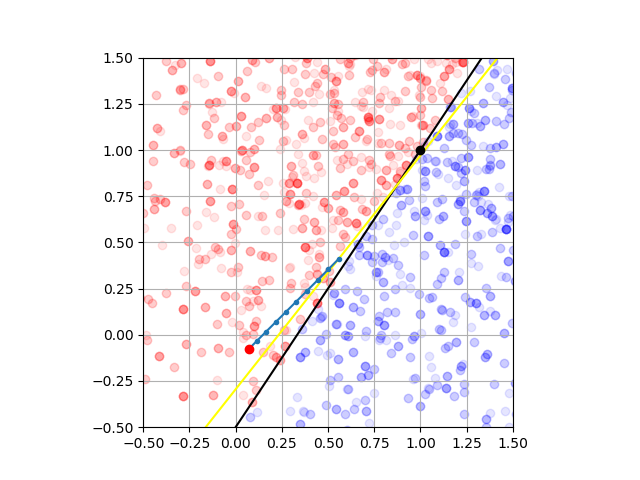

In [28]:
# compare center with target (1,1)

# plot the theoritical zero line (the separator )
b = -np.matmul(sep_plane,data_centers)
X = np.arange(-0.5,1.6, 0.1)
zero_line = -(sep_plane[0]*X+b)/sep_plane[1]
plt.plot(X,zero_line, color='black', label='theoretical separator')

# final zero line
W = model.fl.weights.detach().numpy()[0]
center = model.fl.centers.detach().numpy()[0]
b = -np.matmul(W,center)
final_zero_line = -(W[0]*X+b)/W[1]
plt.plot(X,final_zero_line, color='yellow', label='final separator')


x, y = zip(*train_res['histories']['fl.centers'][:,0,:])
plt.plot(x,y, marker='.', linestyle='-', label='path of neuron center')

# plot start
x,y = train_res['histories']['fl.centers'][0,0,:]
plt.plot(x,y, marker='o', linestyle=' ', markersize=6, color="red", label='start of neuron center')
# plot target
x, y = data_centers
plt.plot(x,y, marker='o', linestyle=' ', markersize=6, color="black", label='theoretical center')


# uncomment if you want to see the data and tighten the window
plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='red')
plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='blue')
plt.axis([-1.5,2.5, -1, 1.5])

# plt.legend()
plt.axis([-0.5,1.5, -0.5,1.5])
plt.grid()
plt.gca().set_aspect("equal")
plt.show()

<IPython.core.display.Javascript object>


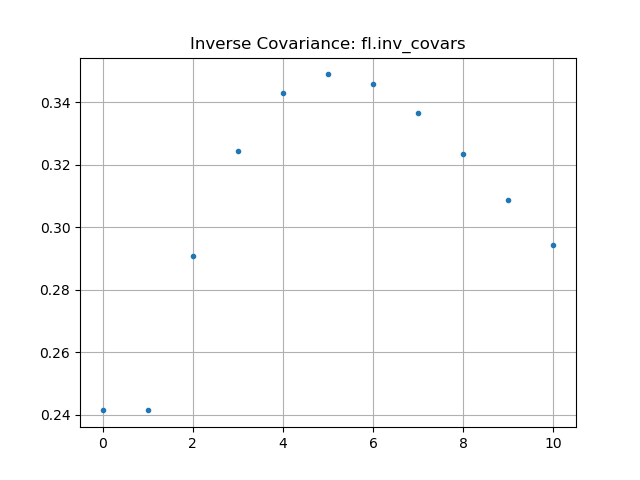

<IPython.core.display.Javascript object>


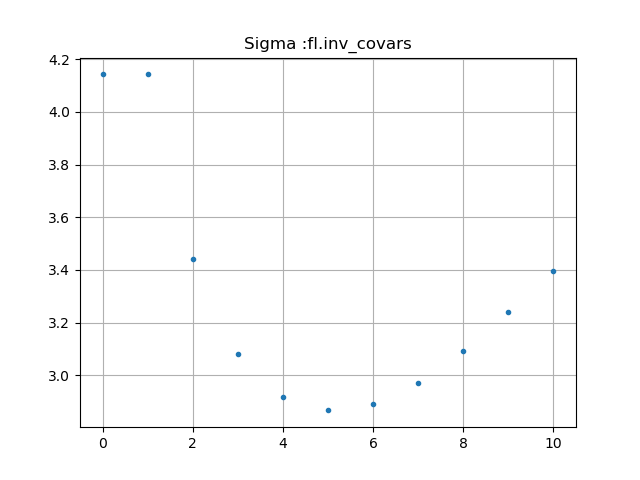

In [29]:
# check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'
fgnl.plot_sigmas_histories(train_res['histories'], covar_type=covar_type)

<IPython.core.display.Javascript object>


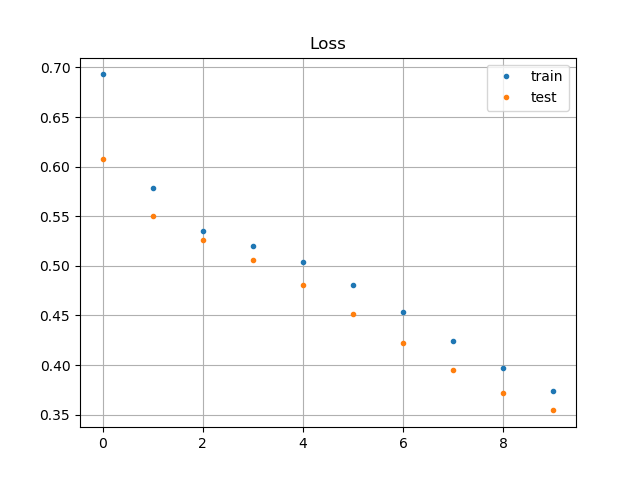

<IPython.core.display.Javascript object>


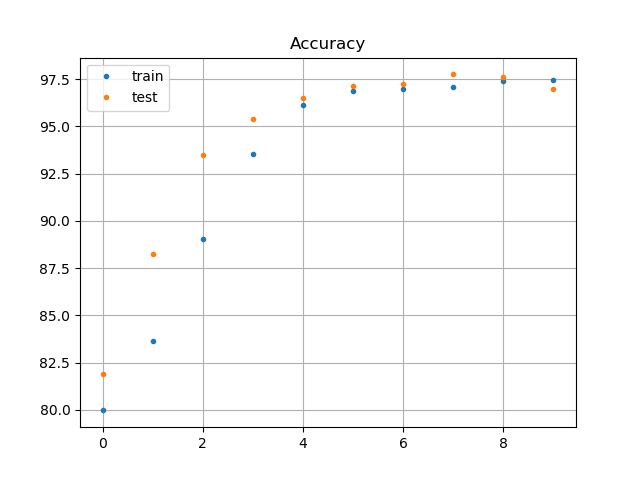

In [30]:
# acc and loss hist
plt.plot(train_res['train_loss_hist'], marker='.', linestyle=' ', label='train')
plt.plot(train_res['test_loss_hist'], marker='.', linestyle=' ', label='test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(train_res['train_acc_hist'], marker='.', linestyle=' ', label='train')
plt.plot(train_res['test_acc_hist'], marker='.', linestyle=' ', label='test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [31]:
# initial activity (gaussian, full)
# visualize neuron activity over data space
# extracts the parameters and shows theoritial neuron activity

# combining circular gaussian with normal neuron
# neuron parameters (weights, bias)
W = model.fl.weights.detach().numpy()[0]
print("weights:",W)

# radial parameters
center = model.fl.centers.detach().numpy()[0] # controls the center of gaussian (<=> bias of neuron)
# plot center as red dot
plt.plot(center[0], center[1], marker='o', markersize=4, color="red")

print("center:",center)

# if bias is defined by center
b1 = -np.matmul(W,center)
# if bias is a free param
b2 = model.fl.biases.detach().numpy()[0]
print("bias from centers:",b1)
print("bias from params (same if free_biases==False):",b2)
# new zero line
zero_line = -(W[0]*X1+b2)/W[1]

# heatmap neuronal activity
n_activity = np.tanh(np.sum(W*heatmap_inputs, axis=1)+b2)
# print(n_activity.shape)

distances = heatmap_inputs-center

# heatmap radial activity 
if covar_type == 'sphere':
    inv_covar = model.fl.inv_covars.detach().numpy()[0]
    sig = 1.0/inv_covar
    r_activity = np.exp((-1.0/abs(sig)**2) *  np.sum(np.square(heatmap_inputs-center), axis=1))
    
elif covar_type == 'diag':
    inv_covar = model.fl.inv_covars.detach().numpy()[0]
    sig = 1.0/inv_covar
    ded = np.einsum('ij,ij->i', distances*abs(inv_covar)**2, distances)
    r_activity = np.exp(-ded)

elif covar_type == 'full':
    inv_covar = model.fl.inv_covars.detach().numpy()[0]
    sig = np.linalg.inv(np.matmul(inv_covar,inv_covar))
    ded = np.einsum('lzi,zik,lzk->lz', distances, inv_covars, distances)
    r_activity = np.exp(-ded)
    
elif covar_type == 'chol':
    inv_covar = model.fl.inv_covars.detach().numpy()[0]
    sig = np.linalg.inv(np.matmul(inv_covar,inv_covar))
    ded = np.einsum('zi,ij,kj,zk->z', distances, inv_covar, inv_covar, distances)
    r_activity = np.exp(-ded)

print("inv covar:", inv_covar)
print("sig:", sig)

weights: [-0.87455094  0.6911759 ]
center: [0.55814797 0.4111529 ]
bias from centers: 0.20394987
bias from params (same if free_biases==False): 0.20394987
inv covar: 0.29433984
sig: 3.397433438844049


<IPython.core.display.Javascript object>


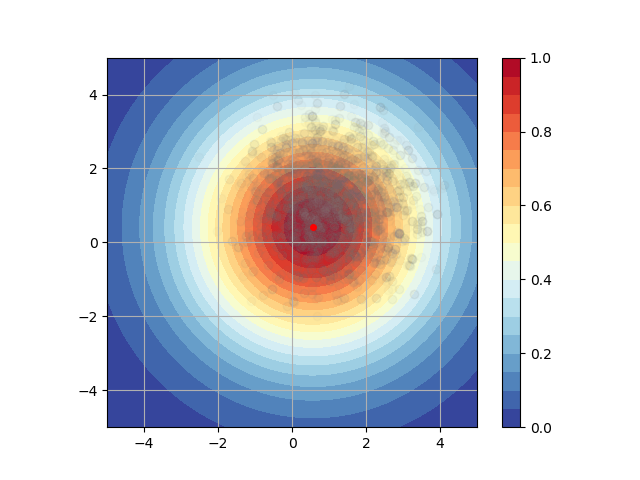

In [32]:
# draw just the gaussian activity and the data
plt.contourf(X1s, X2s, np.reshape(r_activity, np.shape(X1s) ), levels=np.arange(0,1.05, 0.05), cmap= mpl.cm.RdYlBu_r)

plt.colorbar(ticks=np.arange(0,1.1, 0.2))

# uncomment if you want to see the data and tighten the window
plt.scatter(samples_x_1, samples_y_1, alpha=0.03, c='gray')
plt.scatter(samples_x_2, samples_y_2, alpha=0.03, c='gray')
# plt.axis([-1.5,2.5, -1, 1.5])

#reset axes
plt.axis([-5,5, -5, 5])
plt.grid(True)
plt.gca().set_aspect("equal")
plt.show()

<IPython.core.display.Javascript object>


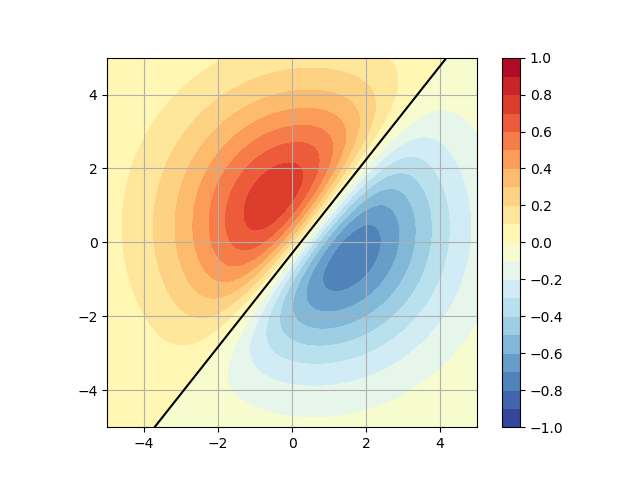

In [33]:
# overall heatmap activity
activity = n_activity*r_activity
# clip to +-1
# activity = np.clip(activity, a_max=0.999, a_min=-1.0)

# plot the zero line
plt.plot(X1,zero_line, color='black')
# plot the heatmap 
plt.contourf(X1s, X2s, np.reshape(activity, np.shape(X1s) ), levels=np.arange(-1,1.05, 0.1), cmap=cm.RdYlBu_r)

plt.colorbar(ticks=np.arange(-1,1.1, 0.2))
#reset axes
plt.axis([-5,5, -5, 5])
plt.grid(True)
plt.gca().set_aspect("equal")
plt.show()

In [34]:
# applies the model to get the actual heatmap
# results might be slightly different based on adding a tanh() or not, clipping of output, ordinal!=2 etc...
# should be close to above
model.eval()
heatmap_inputs_torch = torch.Tensor(heatmap_inputs)
heatmap_preds = model(heatmap_inputs_torch.to(device))
heatmap_preds = heatmap_preds.cpu().detach().numpy()

<IPython.core.display.Javascript object>


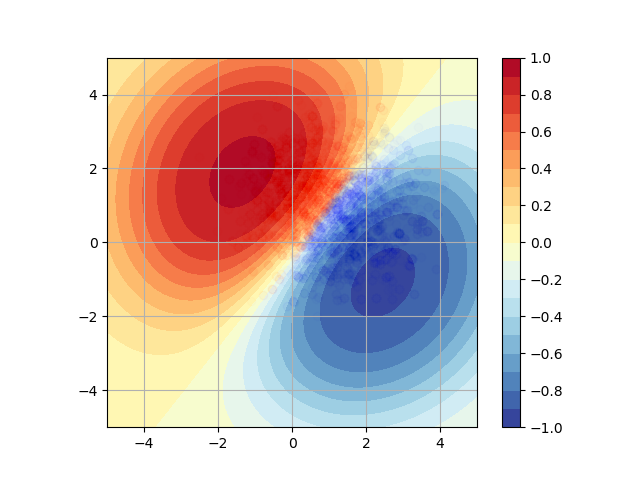

In [35]:
plt.contourf(X1s, X2s, np.reshape(heatmap_preds[:,0], np.shape(X1s) ),levels=np.arange(-1,1.05, 0.1), cmap= mpl.cm.RdYlBu_r)
plt.colorbar(ticks=np.arange(-1,1.1, 0.2))

# uncomment if you want to see the data and tighten the window
plt.scatter(samples_x_1, samples_y_1, alpha=0.01, c='red')
plt.scatter(samples_x_2, samples_y_2, alpha=0.01, c='blue')
# plt.axis([-1.5,2.5, -1, 1.5])

plt.grid(True)
plt.gca().set_aspect("equal")
plt.show()

In [36]:
# now train with much larger lmbda_sigs

In [37]:
# importances of the constraints
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
lmbda_sigs *= 5

print(lmbda_l2)
print(lmbda_sigs)

# loss function
def loss_func(model, output, target):
    
    # normal MSE loss
    mse_loss = F.mse_loss(output, target)
    
    # sum of sigma squares loss
    sig_loss = fgnl.sigmas_loss(model)

    # l2 loss
    l2_loss = fgnh.l2_loss(model)
    
    # (old) negative log likelihood over gaussian loss
#     nllg_loss = 100.0*lmbda*torch.sum(likelihood)
#     nllg_loss = 0.0*torch.mean(likelihood)
    
    return mse_loss + lmbda_l2*l2_loss + lmbda_sigs*sig_loss 

0.000125
0.025


In [38]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.03,)

In [39]:
epochs = 100
train_res = fgnh.train(model, my_dataloader, loss_func, optimizer, epochs, save_hist=2, verbose=True, pred_func=pred_func, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 0.5870, Accuracy: 3115/3200 (97%)
Test set - Average loss: 0.5350, Accuracy: 773/800 (97%)
Epoch 1 Train set - Average loss: 0.5363, Accuracy: 3109/3200 (97%)
Test set - Average loss: 0.4990, Accuracy: 773/800 (97%)
Epoch 2 Train set - Average loss: 0.4998, Accuracy: 3108/3200 (97%)
Test set - Average loss: 0.4728, Accuracy: 773/800 (97%)
Epoch 3 Train set - Average loss: 0.4734, Accuracy: 3106/3200 (97%)
Test set - Average loss: 0.4535, Accuracy: 771/800 (96%)
Epoch 4 Train set - Average loss: 0.4540, Accuracy: 3100/3200 (97%)
Test set - Average loss: 0.4390, Accuracy: 769/800 (96%)
Epoch 5 Train set - Average loss: 0.4395, Accuracy: 3091/3200 (97%)
Test set - Average loss: 0.4276, Accuracy: 767/800 (96%)
Epoch 6 Train set - Average loss: 0.4282, Accuracy: 3088/3200 (96%)
Test set - Average loss: 0.4183, Accuracy: 764/800 (96%)
Epoch 7 Train set - Average loss: 0.4190, Accuracy: 3082/3200 (96%)
Test set - Average loss: 0.4101, Accuracy: 764/800 (96%)


Test set - Average loss: 0.2520, Accuracy: 773/800 (97%)
Epoch 66 Train set - Average loss: 0.2544, Accuracy: 3106/3200 (97%)
Test set - Average loss: 0.2503, Accuracy: 773/800 (97%)
Epoch 67 Train set - Average loss: 0.2531, Accuracy: 3107/3200 (97%)
Test set - Average loss: 0.2485, Accuracy: 773/800 (97%)
Epoch 68 Train set - Average loss: 0.2518, Accuracy: 3109/3200 (97%)
Test set - Average loss: 0.2467, Accuracy: 774/800 (97%)
Epoch 69 Train set - Average loss: 0.2504, Accuracy: 3111/3200 (97%)
Test set - Average loss: 0.2449, Accuracy: 774/800 (97%)
Epoch 70 Train set - Average loss: 0.2491, Accuracy: 3109/3200 (97%)
Test set - Average loss: 0.2432, Accuracy: 777/800 (97%)
Epoch 71 Train set - Average loss: 0.2479, Accuracy: 3111/3200 (97%)
Test set - Average loss: 0.2415, Accuracy: 782/800 (98%)
Epoch 72 Train set - Average loss: 0.2467, Accuracy: 3115/3200 (97%)
Test set - Average loss: 0.2399, Accuracy: 783/800 (98%)
Epoch 73 Train set - Average loss: 0.2456, Accuracy: 3123/320

In [40]:
# model stats post tunning
print(model)
print([p.size() for p in list(model.parameters())])
# print([p for p in list(model.parameters())])
print("Training?", model.training) 
print(model.state_dict())

print("losses")
print(fgnh.l2_loss(model))
print(fgnl.sigmas_loss(model))

FGNet(
  (fl): FGN_layer()
)
[torch.Size([1, 2]), torch.Size([1]), torch.Size([1, 2]), torch.Size([1])]
Training? False
OrderedDict([('fl.weights', tensor([[-2.8624,  1.7765]])), ('fl.biases', tensor([1.1875])), ('fl.centers', tensor([[1.0435, 1.0129]])), ('fl.inv_covars', tensor([0.5410]))])
losses
tensor([11.3491], grad_fn=<DivBackward0>)
tensor([3.4165], grad_fn=<DivBackward0>)


<IPython.core.display.Javascript object>


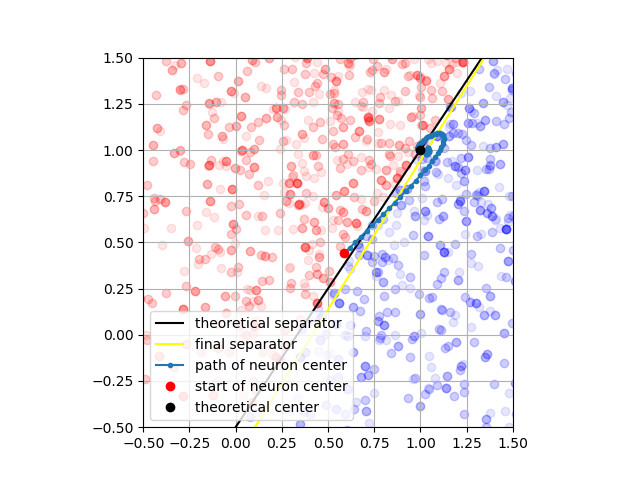

In [41]:
# compare center with target (1,1)

# plot the zero line
b = -np.matmul(sep_plane,data_centers)
X = np.arange(-0.5,1.6, 0.1)
zero_line = -(sep_plane[0]*X+b)/sep_plane[1]
plt.plot(X,zero_line, color='black', label='theoretical separator')

# final zero line
W = model.fl.weights.detach().numpy()[0]
center = model.fl.centers.detach().numpy()[0]
b = -np.matmul(W,center)
final_zero_line = -(W[0]*X+b)/W[1]
plt.plot(X,final_zero_line, color='yellow', label='final separator')


x, y = zip(*train_res['histories']['fl.centers'][:,0,:])
plt.plot(x,y, marker='.', linestyle='-', label='path of neuron center')

# plot start
x,y = train_res['histories']['fl.centers'][0,0,:]
plt.plot(x,y, marker='o', linestyle=' ', markersize=6, color="red", label='start of neuron center')
# plot target
x, y = data_centers
plt.plot(x,y, marker='o', linestyle=' ', markersize=6, color="black", label='theoretical center')

# uncomment if you want to see the data and tighten the window
plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='red')
plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='blue')
# plt.axis([-1.5,2.5, -1, 1.5])

plt.legend()
plt.axis([-0.5,1.5, -0.5,1.5])
plt.grid()
plt.gca().set_aspect("equal")
plt.show()

<IPython.core.display.Javascript object>


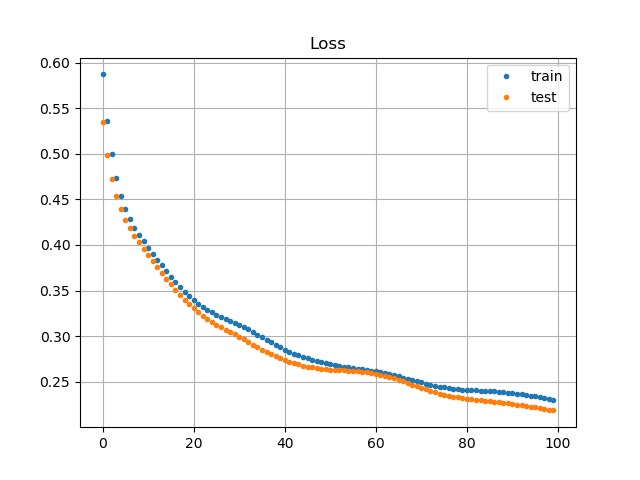

<IPython.core.display.Javascript object>


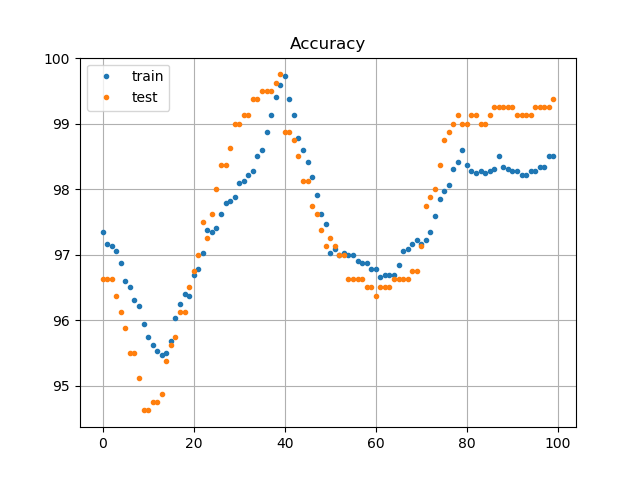

In [42]:
# acc and loss hist
plt.plot(train_res['train_loss_hist'], marker='.', linestyle=' ', label='train')
plt.plot(train_res['test_loss_hist'], marker='.', linestyle=' ', label='test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(train_res['train_acc_hist'], marker='.', linestyle=' ', label='train')
plt.plot(train_res['test_acc_hist'], marker='.', linestyle=' ', label='test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

<IPython.core.display.Javascript object>


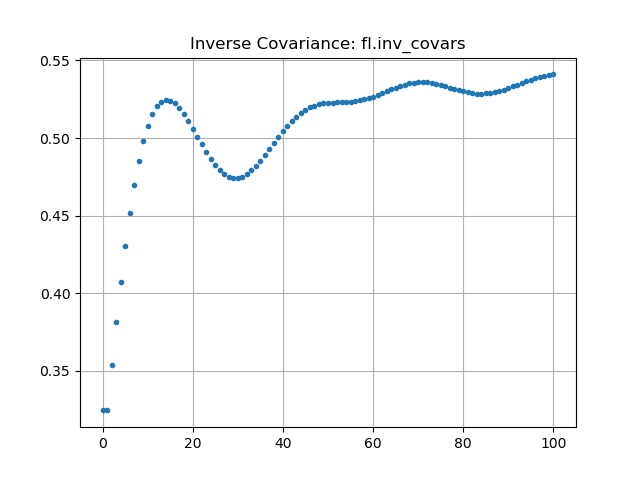

<IPython.core.display.Javascript object>


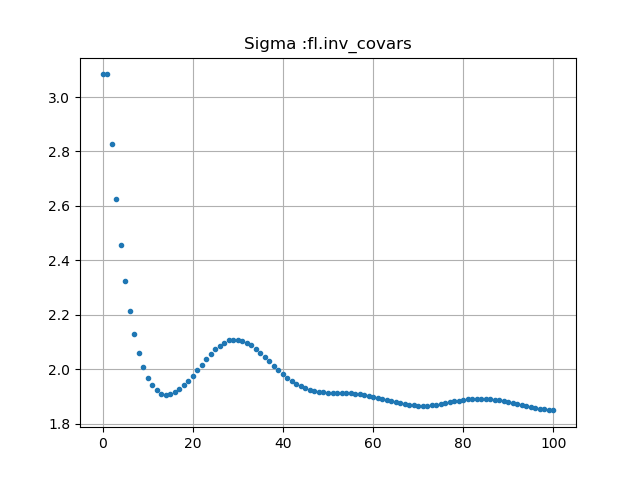

In [43]:
# check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'
fgnl.plot_sigmas_histories(train_res['histories'], covar_type=model.covar_type)

weights: [-2.8623555  1.7765249]
center: [1.0435362 1.0129112]
bias from centers: 1.1875097
bias from params (same if free_biases==False): 1.1875097
inv covar: 0.5410149
sig: 1.8483778949321363


<IPython.core.display.Javascript object>


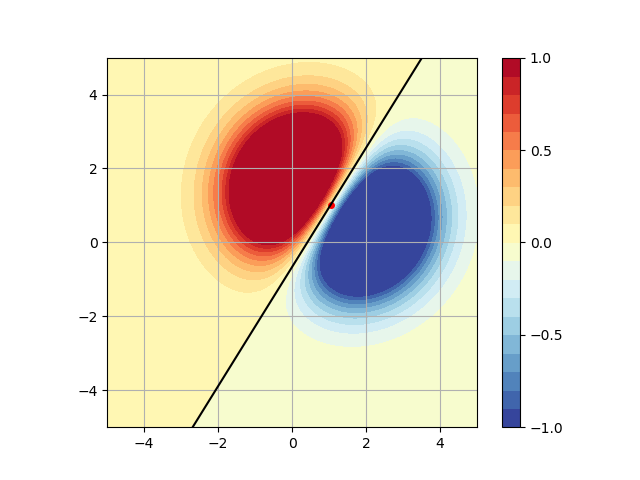

In [44]:
# visualize neuron activity over data space
# extracts the parameters and shows theoritial neuron activity

# combining circular gaussian with normal neuron
# neuron parameters (weights, bias)
W = model.fl.weights.detach().numpy()[0]
print("weights:",W)
# b = 0 # bias defined by by the center of radial function

# radial parameters
center = model.fl.centers.detach().numpy()[0] # controls the center of gaussian (<=> bias of neuron)
# plot center as red dot
plt.plot(center[0], center[1], marker='o', markersize=4, color="red")

print("center:",center)

# if bias is defined by center
b1 = -np.matmul(W,center)
# if bias is a free param
b2 = model.fl.biases.detach().numpy()[0]
print("bias from centers:",b1)
print("bias from params (same if free_biases==False):",b2)
# new zero line
zero_line = -(W[0]*X1+b2)/W[1]

# heatmap neuronal activity
n_activity = np.sum(W*heatmap_inputs, axis=1)+b
# print(n_activity.shape)

distances = heatmap_inputs-center

# heatmap radial activity 
if covar_type == 'sphere':
    inv_covar = model.fl.inv_covars.detach().numpy()[0]
    sig = 1.0/inv_covar
    r_activity = np.exp((-1.0/abs(sig)**2) *  np.sum(np.square(heatmap_inputs-center), axis=1))
    
elif covar_type == 'diag':
    inv_covar = model.fl.inv_covars.detach().numpy()[0]
    sig = 1.0/inv_covar
    ded = np.einsum('ij,ij->i', distances*abs(inv_covar)**2, distances)
    r_activity = np.exp(-ded)

elif covar_type == 'full':
    inv_covar = model.fl.inv_covars.detach().numpy()[0]
    sig = np.linalg.inv(np.matmul(inv_covar,inv_covar))
    ded = np.einsum('lzi,zik,lzk->lz', distances, inv_covars, distances)
    r_activity = np.exp(-ded)
    
elif covar_type == 'chol':
    inv_covar = model.fl.inv_covars.detach().numpy()[0]
    sig = np.linalg.inv(np.matmul(inv_covar,inv_covar))
    ded = np.einsum('zi,ij,kj,zk->z', distances, inv_covar, inv_covar, distances)
    r_activity = np.exp(-ded)

print("inv covar:", inv_covar)
print("sig:", sig)

    
# overall heatmap activity
activity = n_activity*r_activity
# clip to +-1
activity = np.clip(activity, a_max=0.999, a_min=-1.0)

# plot the zero line
plt.plot(X1,zero_line, color='black')
# plot the heatmap 
# maxi = 1.0
# levels = np.arange(-maxi, maxi+0.1,maxi/10.0)
# ticks = np.arange(-maxi, maxi+0.1, maxi/5.0)

levels = np.arange(-1.0, 1.0+0.001, 1/10.)
ticks = levels[::5]


plt.contourf(X1s, X2s, np.reshape(activity, np.shape(X1s) ), levels=levels, cmap=cm.RdYlBu_r)

plt.colorbar(ticks=ticks)
#reset axes
plt.axis([-scale,scale, -scale, scale])
plt.grid(True)
plt.gca().set_aspect("equal")
plt.show()

In [45]:
# applies the model to get the actual heatmap
# results might be slightly different based on adding a tanh() or not, clipping of output, ordinal!=2 etc...
# should be close to above
model.eval()
heatmap_inputs = torch.Tensor(heatmap_inputs)
heatmap_preds = model(heatmap_inputs.to(device))
heatmap_preds = heatmap_preds.cpu().detach().numpy()

<IPython.core.display.Javascript object>


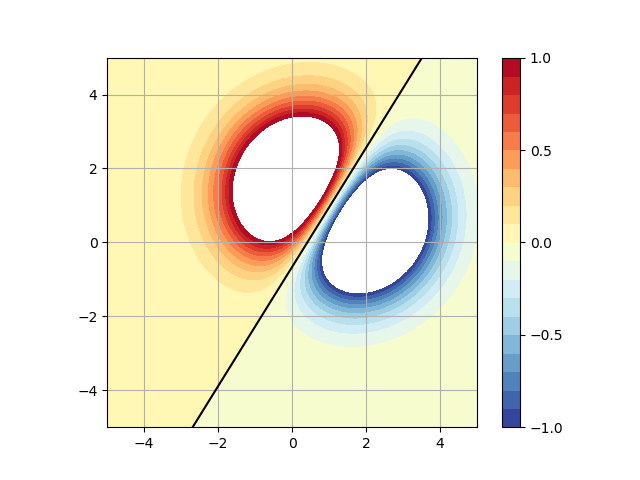

In [46]:
# overall heatmap activity
activity = n_activity*r_activity
# clip to +-1
# activity = np.clip(activity, a_max=0.999, a_min=-1.0)

# plot the zero line
plt.plot(X1,zero_line, color='black')
# plot the heatmap 
# maxi = 1.0
# levels = np.arange(-maxi, maxi+0.1,maxi/10.0)
# ticks = np.arange(-maxi, maxi+0.1, maxi/5.0)


plt.contourf(X1s, X2s, np.reshape(activity, np.shape(X1s) ), levels=levels, cmap=cm.RdYlBu_r)

plt.colorbar(ticks=ticks)
#reset axes
plt.axis([-5,5, -5, 5])
plt.grid(True)
plt.gca().set_aspect("equal")
plt.show()

<IPython.core.display.Javascript object>


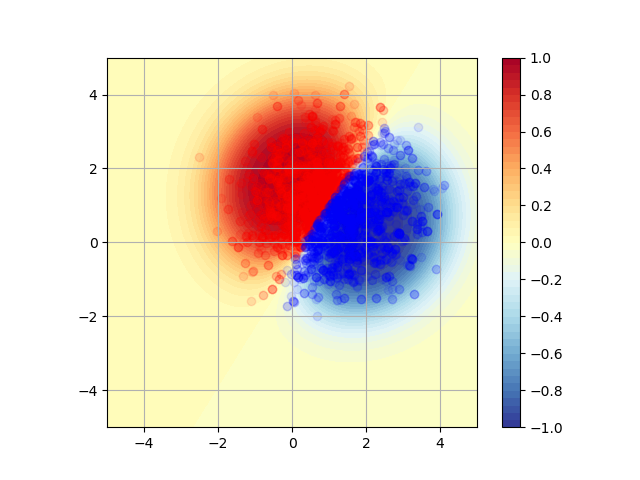

In [47]:
levels = np.arange(-1.0, 1.0+0.001, 5**(-2))
ticks = levels[::5]

plt.contourf(X1s, X2s, np.reshape(heatmap_preds[:,0], np.shape(X1s) ),levels=levels, cmap= cm.RdYlBu_r)
plt.colorbar(ticks=ticks)

# uncomment if you want to see the data and tighten the window
plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='red')
plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='blue')
# plt.axis([-1.5,2.5, -1, 1.5])

plt.grid(True)
plt.gca().set_aspect("equal")
plt.show()

<IPython.core.display.Javascript object>


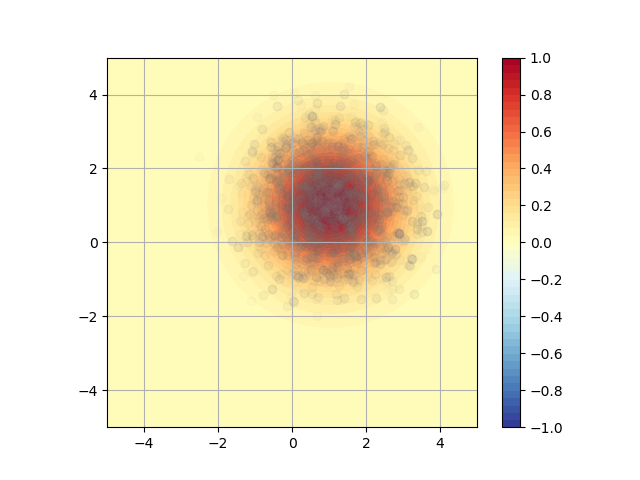

In [48]:
# draw just the gaussian activity and the data
# plot the heatmap 
levels = np.arange(-1.0, 1.0+0.001, 5**(-2))
ticks = levels[::5]

plt.contourf(X1s, X2s, np.reshape(r_activity, np.shape(X1s) ), levels=levels, cmap= mpl.cm.RdYlBu_r)

plt.colorbar(ticks=ticks)

# uncomment if you want to see the data and tighten the window
plt.scatter(samples_x_1, samples_y_1, alpha=0.03, c='gray')
plt.scatter(samples_x_2, samples_y_2, alpha=0.03, c='gray')
# plt.axis([-1.5,2.5, -1, 1.5])

#reset axes
plt.axis([-scale,scale, -scale, scale])
plt.grid(True)
plt.gca().set_aspect("equal")
plt.show()

In [52]:
min(abs(heatmap_preds))

array([3.8182684e-09], dtype=float32)

In [55]:
np.min(np.abs(heatmap_preds))

3.8182684e-09